# **Implementing Attention from Scratch**

Paper: https://arxiv.org/abs/1706.03762


## Step 1: Divide input into tokens and extract embeddings from each token.



For simplicity, let's assume you have one example represented by 4 tokens, each token represented by an embedding of size 3. 

In [2]:
import numpy as np
np.random.seed(4)

n_tokens = 4
emb_dim = 3

emb_rep = np.random.uniform(size=(n_tokens,emb_dim))
emb_rep

array([[0.96702984, 0.54723225, 0.97268436],
       [0.71481599, 0.69772882, 0.2160895 ],
       [0.97627445, 0.00623026, 0.25298236],
       [0.43479153, 0.77938292, 0.19768507]])

## Step 2: Create positional embeddings



Text from the paper: "Since our model contains no recurrence and no convolution, in order for the model to make use of the
order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add 'positional encodings' to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension $d_{model}$ - emb_dim in our code - as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed."

This is what they used in the paper: 



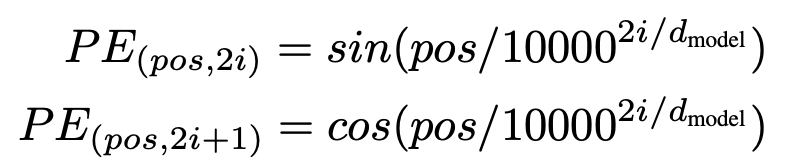

where *pos* is the position of the token in the sequence (in our case, since we have 4 tokens, pos ranges from 0 to 3), and *i* represents an embdedding dimension (in our case, since we use embeddings of size 3, i ranges from 0 to 2).

In [3]:
pos = np.arange(n_tokens)
i = np.arange(emb_dim)

sinusoid_arg = 1/(10000**(i/emb_dim))

pos_t = pos.reshape((-1, 1))
sinusoid_arg = sinusoid_arg.reshape((1,-1))

pos_emd = pos_t @ sinusoid_arg

pos_emd[:,::2] = np.sin(pos_emd[:,::2])
pos_emd[:,1::2] = np.cos(pos_emd[:,1::2])

print(pos_emd)

# sinusoid_arg = pos.T @ sinusoid_arg

[[0.         1.         0.        ]
 [0.84147098 0.99892298 0.00215443]
 [0.90929743 0.99569422 0.00430886]
 [0.14112001 0.9903207  0.00646326]]


## Step 3: Add input and positional embeddings

In [4]:
print("emb_rep\n", emb_rep)
print("pos_emd\n", pos_emd)
emb_rep = emb_rep + pos_emd
print("emb_rep\n", emb_rep)
print("emb_rep.shape\n", emb_rep.shape)

emb_rep
 [[0.96702984 0.54723225 0.97268436]
 [0.71481599 0.69772882 0.2160895 ]
 [0.97627445 0.00623026 0.25298236]
 [0.43479153 0.77938292 0.19768507]]
pos_emd
 [[0.         1.         0.        ]
 [0.84147098 0.99892298 0.00215443]
 [0.90929743 0.99569422 0.00430886]
 [0.14112001 0.9903207  0.00646326]]
emb_rep
 [[0.96702984 1.54723225 0.97268436]
 [1.55628698 1.6966518  0.21824393]
 [1.88557188 1.00192448 0.25729122]
 [0.57591154 1.76970362 0.20414833]]
emb_rep.shape
 (4, 3)


## Step 4: Compute Query, Key, Value matrices

In [5]:
dim_qk = 5
dim_v = 7

W_q = np.random.uniform(size=(emb_dim, dim_qk))
W_k = np.random.uniform(size=(emb_dim, dim_qk))
W_v = np.random.uniform(size=(emb_dim, dim_v))

q = emb_rep @ W_q
k = emb_rep @ W_k
v = emb_rep @ W_v

print("q.shape: ", q.shape)
print("k.shape: ", k.shape)
print("v.shape: ", v.shape)

q.shape:  (4, 5)
k.shape:  (4, 5)
v.shape:  (4, 7)


## Step 5: Create attention scores using Q and K

In [6]:
from scipy.special import softmax

attention_scores = softmax((q @ k.T) / np.sqrt(dim_qk), axis=1)

print("attention_scores.shape: ", attention_scores.shape)
print("attention_scores\n", attention_scores)


attention_scores.shape:  (4, 4)
attention_scores
 [[0.37965353 0.32430831 0.25857327 0.03746489]
 [0.38588555 0.32354765 0.25136182 0.03920498]
 [0.37262363 0.32077205 0.25548236 0.05112196]
 [0.36111936 0.31497959 0.26234658 0.06155447]]


## Step 6: Compute attention head output

In [7]:
attention_head_out = attention_scores @ v
print("attention_head_out.shape: ", attention_head_out.shape)
print("attention_head_out\n", attention_head_out)


attention_head_out.shape:  (4, 7)
attention_head_out
 [[2.44633317 1.77935922 1.47644343 1.84107525 1.69358435 1.28678952
  1.20331499]
 [2.44704884 1.78363618 1.47870694 1.84169269 1.69304248 1.28869591
  1.20123723]
 [2.43591964 1.77885368 1.46944765 1.83625089 1.68225793 1.28400026
  1.19652617]
 [2.42571811 1.77289667 1.46106617 1.83062819 1.67326142 1.27909535
  1.19261518]]


For multi-head attention, concatenate the outputs of all heads and multiply the resulting matrix times a final W_out weight matrix.

In practice, it's common for *key* and *value* to be the same tensor. 

    dim_qk = 5

    W_q = np.random.uniform(size=(emb_dim, dim_qk))
    W_kv = np.random.uniform(size=(emb_dim, dim_qk))

    q = emb_rep @ W_q
    v = emb_rep @ W_kv
    k = v



## Let's try to implement this stuff using Tensorflow

Load libraries

In [8]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style='darkgrid')  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics

Load some data 

In [9]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

np.random.seed(0) # For reproducibility purposes
X_train = X_train / 255.0
X_test = X_test / 255.0

# Shuffle the order of the training examples.
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)

X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)


4422102/4422102 [==============================] - 0s 0us/step
X_train.shape (60000, 28, 28)
X_test.shape (10000, 28, 28)


In [10]:
# Let's represent each image as a sequence of feature vectors
n_patches = 16
n_patch_pixels = (X_train.shape[1] * X_train.shape[2]) // n_patches

# TODO: Get actual patches
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))
X_train = X_train.reshape((X_train.shape[0], n_patches, n_patch_pixels))
X_test = X_test.reshape((X_test.shape[0], n_patches, n_patch_pixels))

print()
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)


X_train.shape (60000, 16, 49)
X_test.shape (10000, 16, 49)


Let's code the network

In [11]:
from tensorflow.keras import layers

def build_model(input_shape, n_classes):
  tf.keras.backend.clear_session()
  # Create the model
  emb_dim = 32
  query_key_dim = 32
  value_dim = 32

  input_layer = tf.keras.Input(shape=input_shape)

  # Extract embeddings of size emb_dim from each patch
  emb_extractor = layers.Dense(emb_dim, activation="relu")
  embeddings = layers.TimeDistributed(emb_extractor)(input_layer)
  # embeddings = input_layer

  query = layers.Dense(query_key_dim)(embeddings)
  key = layers.Dense(query_key_dim)(embeddings)
  value = layers.Dense(value_dim)(embeddings)

  attention_scores = tf.linalg.matmul(query, key, transpose_b=True)
  attention_scores = attention_scores / tf.math.sqrt(float(query_key_dim))

  attention_scores = tf.nn.softmax(attention_scores, axis=-1)

  attention_head_out = tf.linalg.matmul(attention_scores, value)

  x = layers.Flatten()(attention_head_out)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(32, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(16, activation='relu')(x)
  x = layers.Dense(n_classes, name="logits")(x)

  model = tf.keras.Model(input_layer, x)

  return model


In [12]:
model = build_model(X_train[0].shape, 10)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 49)]     0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 16, 32)      1600        ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 dense_1 (Dense)                (None, 16, 32)       1056        ['time_distributed[0][0]']       
                                                                                                  
 dense_2 (Dense)                (None, 16, 32)       1056        ['time_distributed[0][0]']   

In [13]:
# Initiate Stochastic Gradient Descent optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss,
            optimizer=opt,
            metrics=['accuracy'])

# Fit the model.
history = model.fit(
  x = X_train,  
  y = Y_train,  
  epochs=100,     
  batch_size=128, 
  # validation_split=0.1,
  validation_data=(X_test, Y_test),
  verbose=1            
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Epoch 1/100
469/469 [==============================] - 5s 5ms/step - loss: 1.5358 - accuracy: 0.3859 - val_loss: 0.8567 - val_accuracy: 0.7066
Epoch 2/100
469/469 [==============================] - 2s 5ms/step - loss: 0.9262 - accuracy: 0.6419 - val_loss: 0.6733 - val_accuracy: 0.7534
Epoch 3/100
469/469 [==============================] - 2s 4ms/step - loss: 0.7773 - accuracy: 0.7078 - val_loss: 0.6035 - val_accuracy: 0.7723
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 0.7157 - accuracy: 0.7366 - val_loss: 0.5653 - val_accuracy: 0.7938
Epoch 5/100
469/469 [==============================] - 2s 4ms/step - loss: 0.6741 - accuracy: 0.7563 - val_loss: 0.5407 - val_accuracy: 0.7987
Epoch 6/100
469/469 [==============================] - 2s 4ms/step - loss: 0.6512 - accuracy: 0.7694 - val_loss: 0.5207 - val_accuracy: 0.8147
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 0.6266 - accuracy: 0.7808 - val_loss: 0.5277 - val_accuracy: 0.8193

,loss,accuracy,val_loss,val_accuracy
0,1.535806,0.385950,0.856680,0.7066
1,0.926190,0.641917,0.673257,0.7534
2,0.777326,0.707833,0.603454,0.7723
3,0.715739,0.736650,0.565322,0.7938
4,0.674116,0.756317,0.540693,0.7987
...,...,...,...,...
95,0.396450,0.867133,0.394682,0.8641
96,0.395802,0.868083,0.391094,0.8657
97,0.389076,0.867600,0.395609,0.8644
98,0.390662,0.867483,0.389567,0.8683


In [14]:
from tensorflow.keras import layers

def build_attention_head(embeddings, id):
  emb_dim = 32
  query_key_dim = 32
  value_dim = 32

  query = layers.Dense(query_key_dim)(embeddings)
  key = layers.Dense(query_key_dim)(embeddings)
  value = layers.Dense(value_dim)(embeddings)

  attention_scores = tf.linalg.matmul(query, key, transpose_b=True)
  attention_scores = attention_scores / tf.math.sqrt(float(query_key_dim))

  attention_scores = tf.nn.softmax(attention_scores, axis=-1)

  attention_head_out = tf.linalg.matmul(attention_scores, value)

  return layers.Flatten()(attention_head_out)

def build_multihead_model(input_shape, n_classes):

  # Create the model
  tf.keras.backend.clear_session()

  input_layer = tf.keras.Input(shape=input_shape)

  # Extract embeddings of size emb_dim from each patch
  emb_extractor = layers.Dense(emb_dim)
  embeddings = layers.TimeDistributed(emb_extractor)(input_layer)
  # embeddings = input_layer

  att_heads = []
  for i in range(8):
    att_heads.append(build_attention_head(embeddings, str(i)))
  x = tf.concat(att_heads, axis=-1)

  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(32, activation='relu')(x)
  x = layers.Dense(n_classes, name="logits")(x)

  model = tf.keras.Model(input_layer, x)

  return model


In [15]:
model = build_multihead_model(X_train[0].shape, 10)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 49)]     0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 16, 3)       150         ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 dense_1 (Dense)                (None, 16, 32)       128         ['time_distributed[0][0]']       
                                                                                                  
 dense_2 (Dense)                (None, 16, 32)       128         ['time_distributed[0][0]']   

In [ ]:
# Initiate Stochastic Gradient Descent optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss,
            optimizer=opt,
            metrics=['accuracy'])

# Fit the model.
history = model.fit(
  x = X_train,  
  y = Y_train,  
  epochs=100,     
  batch_size=128, 
  # validation_split=0.1,
  validation_data=(X_test, Y_test),
  verbose=1            
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Epoch 1/100
469/469 [==============================] - 8s 10ms/step - loss: 1.3899 - accuracy: 0.4746 - val_loss: 0.7370 - val_accuracy: 0.7083
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.7861 - accuracy: 0.7082 - val_loss: 0.6391 - val_accuracy: 0.7590
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6898 - accuracy: 0.7467 - val_loss: 0.5746 - val_accuracy: 0.7808
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6359 - accuracy: 0.7675 - val_loss: 0.5352 - val_accuracy: 0.8083
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.5949 - accuracy: 0.7819 - val_loss: 0.5271 - val_accuracy: 0.8138
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.5673 - accuracy: 0.7933 - val_loss: 0.5111 - val_accuracy: 0.8242
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.5421 - accuracy: 0.8020 - val_loss: 0.4983 - val_accuracy: 0.821